# 6. Time-Domain simulations


## Performance Tips

First, we do the necessary setup: imports, shape, flake and field definition 

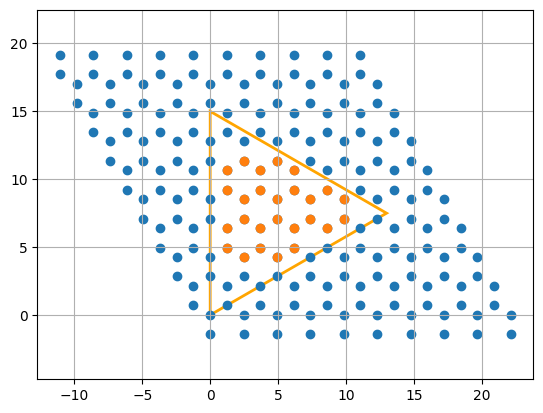

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from granad import MaterialCatalog, Pulse, Triangle, Wave
import diffrax # is behind the time propagation

triangle = Triangle(15, armchair = True)
flake = MaterialCatalog.get("graphene").cut_flake(triangle, plot = True)
pulse = Pulse(
    amplitudes=[1e-5, 0, 0], frequency=1., peak = 4, fwhm = 2
)

The dynamics of any observable depend on the density matrix. The function get_expectation_value_frequency_domain essentially

1. samples density matrices in time
2. computes the time-dependent expectation value
3. Fourier transforms it.

This is fine if we want to simulate a single observable, but means that we have to rerun the simulation for every observable. To save time, we can do the TD simulation by hand, save the density matrices and then compute expectation values without needing to recompute.

In [2]:
time, density_matrices =  flake.get_density_matrix_time_domain(
        end_time=40,
        steps_time=1e6,
        relaxation_rate=1/10,
        illumination=pulse,
        skip=100,
)
print(density_matrices.shape)

(10000, 26, 26)


Now, we have density matrices in time domain. The first axis is time, the last two axis correspond to the dimension of the one particle Hilbert space. Let's compute expectation values for the dipole operator by hand

In [3]:
p = flake.get_expectation_value( density_matrix = density_matrices, operator = flake.dipole_operator )

You might have noticed that neither the density_matrices nor the dipole_operator are square matrices. The function can still handle that. Let's inspect the shape of the dipole moments

In [4]:
print(p.shape)

(10000, 3)


So, the first axis is time, the last axis corresponds to x,y,z  Cartesian coordinates.

Let's do the same computation in Fourier space: we can avoid recomputation by passing the TD density matrix as an explicit argument

In [5]:
omegas, p_omega = flake.get_expectation_value_frequency_domain(
    operator=flake.dipole_operator,  # the dipole moment is the expectation value of the dipole operator
    time=time,
    density_matrices = density_matrices,
    omega_min = 0,
    omega_max = 10,    
)
print(p_omega.shape)

(64, 3)


So, the first axis is the Fourier partner of time, the frequency, and the last axis still corresponds to x,y,z  Cartesian coordinates.

## Options

The time evolution relies on [diffrax](https://docs.kidger.site/diffrax). You can pass [solvers](https://docs.kidger.site/diffrax/usage/how-to-choose-a-solver/) directly to any function calling the time domain evolution. By default, we use 5-th order Runge Kutta with adaptive step size, where the relative and absolute tolerance are set to 1e-10.

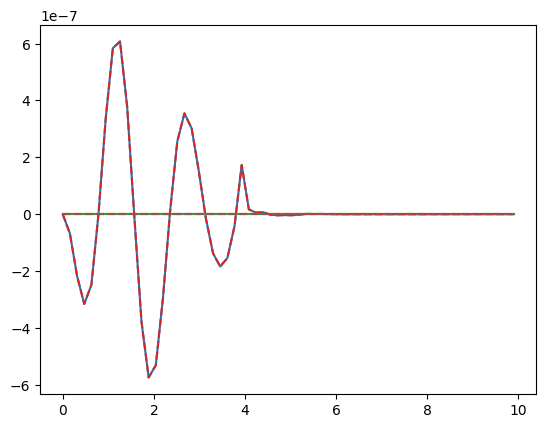

In [6]:
omegas, p_omega_8 = flake.get_expectation_value_frequency_domain(
    operator=flake.dipole_operator, 
    time=time,
    density_matrices = density_matrices,
    omega_min = 0,
    omega_max = 10,
    solver = diffrax.Dopri8(),
)
plt.plot(omegas, p_omega)
plt.plot(omegas, p_omega_8, '--')
plt.show()

We see that we have pretty good agreement.

## Convergence

To check convergence, we can

1. Decrease the initial step size by passing a higher value for steps_time
2. Choose a more accurate diffrax solver
3. Check physical consistency with the continuity equation

We will look at the third example. The continuity equation relates the dipole moment and the (longitudinal) current

$$\nabla j = \partial_t \rho = \partial_t \nabla P \implies j = \partial_t P$$

In Fourier space, we can write equivalently

$$-i \omega p(\omega) = j(\omega)$$

The current operator is, a bit confusingly, called velocity operator in GRANAD, since atomic units are used, where q = 1 and $j = q v$. 

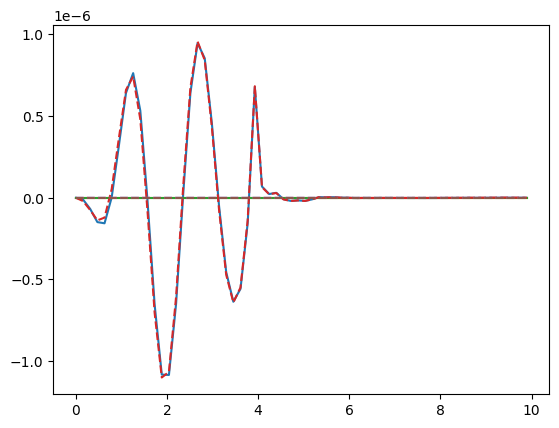

In [7]:
omegas, j_omega = flake.get_expectation_value_frequency_domain(
    operator=flake.velocity_operator,  
    time=time,
    density_matrices = density_matrices,
    omega_min = 0,
    omega_max = 10,        
)

p_omega_0 = p_omega
j_omega_0 = j_omega
j_term = j_omega_0.imag
p_term =  omegas[:,None] * p_omega_0.real
plt.plot( omegas, p_term )
plt.plot( omegas, j_term, '--' )
plt.show()

We see that the continuity equation holds.

## Resuming simulations

TD simulations can be resumed. This is useful, e.g. when computing the EPI, where the system needs to have reached a steady state. Let's compute the EPI for our tiny triangle. First, we propagate the system in time and check the oscillation of the dipole moment

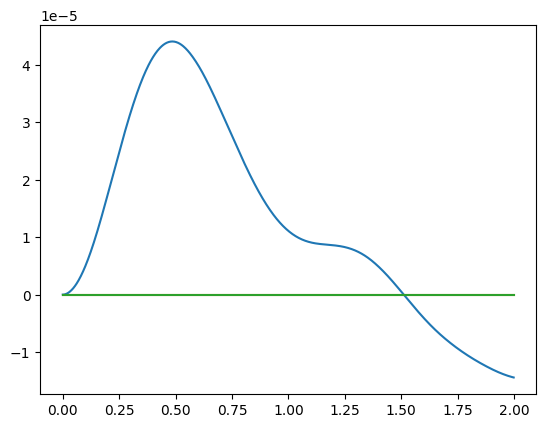

In [8]:
end_time = 2
wave = Wave( amplitudes=[1e-5, 0, 0], frequency=1. )
time, density_matrices =  flake.get_density_matrix_time_domain(
        end_time=end_time,
        steps_time=1e6,
        relaxation_rate=1/10,
        illumination=wave,
        skip=1000,
)
p = flake.get_expectation_value( density_matrix = density_matrices, operator = flake.dipole_operator )
plt.plot(time, p)
plt.show()

The dipole moment doesn't look periodic, so the system is likely not in a steady state. We can push the system further in time by supplying

1. the time we ended the simulation as start time
2. the last density matrix we sampled

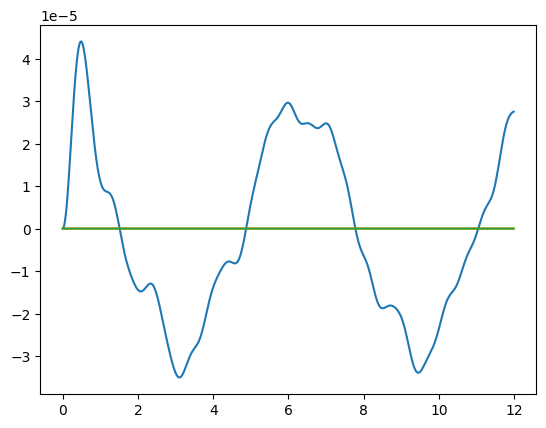

In [9]:
time_new, density_matrices_new =  flake.get_density_matrix_time_domain(
        start_time=end_time,
        end_time=end_time+10,
        initial_density_matrix = density_matrices[-1],
        steps_time=1e6,
        relaxation_rate=1/10,
        illumination=wave,
        skip=1000,
)
p_new = flake.get_expectation_value( density_matrix = density_matrices_new, operator = flake.dipole_operator )
plt.plot( jnp.concatenate([time, time_new]), jnp.concatenate([p, p_new]) )
plt.show()

We can repeat this process until we have visual confirmation of the steady state:

1. continue simulation with end_time increased and the initial density matrix set to the last density matrix
2. repeat 1 if the result is not periodic

GRANAD offers a way you can try to automate this process: the function "fraction_periodic" tries to compute the fraction of a signal that is periodic. Let's look at it

In [10]:
from granad import fraction_periodic
help(fraction_periodic)

Help on function fraction_periodic in module granad._numerics:

fraction_periodic(signal, threshold=0.01)
    Estimates the fraction of a periodic component in a given signal by analyzing the deviation of the cumulative mean from its median value. The periodicity is inferred based on the constancy of the cumulative mean of the absolute value of the signal.

    Parameters:
        signal (jax.Array): A 1D array representing the signal of interest.
        threshold (float, optional): A threshold value to determine the significance level of deviation from periodicity. Defaults to 0.01.

    Returns:
        float: A ratio representing the fraction of the signal that is considered periodic, based on the specified threshold.

    Example:
        >>> import jax.numpy as jnp
        >>> signal = jnp.array([0.1, 0.2, 0.1, 0.2, 0.1, 0.2])
        >>> print(fraction_periodic(signal))
        0.995



In our case, the signal to check for periodicity is the dipole moment: once it is periodic, we have hit a steady state. We can define a custom function to test this

In [11]:
def is_steady( density_matrices ):
    p = flake.get_expectation_value( operator = flake.dipole_operator, density_matrix = density_matrices )
    if fraction_periodic(p[:,0], threshold = 1e-1) > 0.8:
        return True
    return False

We chose the value of 0.8 somewhat arbitrarily, but the exact value probably doesn't matter that much in practice if it's high enough (> 0.5). Our automated loop looks like this

In [12]:
loop_iterations = 0
while is_steady( density_matrices ) == False and loop_iterations < 10:
    start_time = end_time
    end_time = end_time + 10
    time_new, density_matrices_new =  flake.get_density_matrix_time_domain(
        start_time = start_time,
        end_time = end_time,
        initial_density_matrix = density_matrices[-1],
        steps_time=1e6,
        relaxation_rate=1/10,
        illumination=wave,
        skip=1000,
    )
    density_matrices = jnp.concatenate( [density_matrices, density_matrices_new] )
    time = jnp.concatenate( [time, time_new] )
    loop_iterations += 1

print( is_steady(density_matrices) )

True


Now, we plot

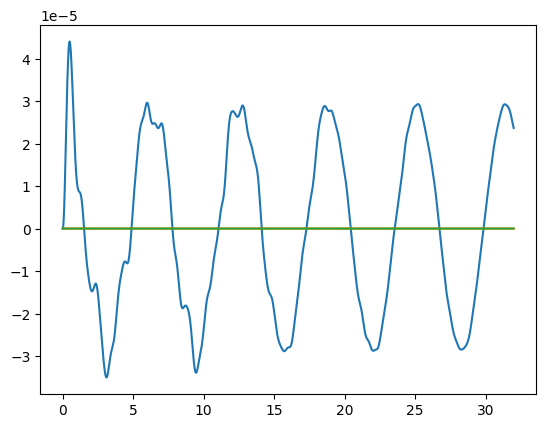

In [13]:
p = flake.get_expectation_value( operator = flake.dipole_operator, density_matrix = density_matrices )
plt.plot( time, p )
plt.show()

We have correctly identified periodicity and thus the density matrix density_matrices[-1] can be taken as a steady state for epi calculation

In [14]:
print(flake.get_epi( flake.transform_to_energy_basis(density_matrices[-1]), omega = 1.0 ))

0.19040759965429377
